In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch

In [3]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [4]:
a=torch.tensor([[2,1,3],
             [4,5,6]])

In [5]:
a.shape

torch.Size([2, 3])

In [6]:
type(a[0][1])

torch.Tensor

In [7]:
a.dtype

torch.int64

In [8]:
#a=torch.tensor([[2,1,3],
            # [4,5,6,7]])

In [9]:
a=torch.tensor([[2.,1.,3.],
             [4.,5.,6]])

In [10]:
type(a[0][1])

torch.Tensor

In [11]:
a.dtype

torch.float32

In [12]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [13]:
x1.grad

tensor([-1.5000], dtype=torch.float64)

In [14]:
import random
import math

In [15]:
#copied from micrograd notebook
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out

  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [16]:
class Neuron:

    # When a neuron is born, give it random weights and bias.
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        #self.w = [w1, w2, w3]
        #x      = [x1, x2, x3]
        #zip → [(w1,x1), (w2,x2), (w3,x3)]
        out = act.tanh()
        return out


x=[2.0,3.0]
n=Neuron(2)
n(x)

Value(data=0.5483857147231094)

In [17]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

x=[2.0,3.0]
n=Layer(2,3)
n(x)
  

[Value(data=-0.8958804593742625),
 Value(data=-0.9700783129539298),
 Value(data=-0.8471222812736415)]

In [18]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.7471488809330902)

In [19]:
import graphviz

In [20]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

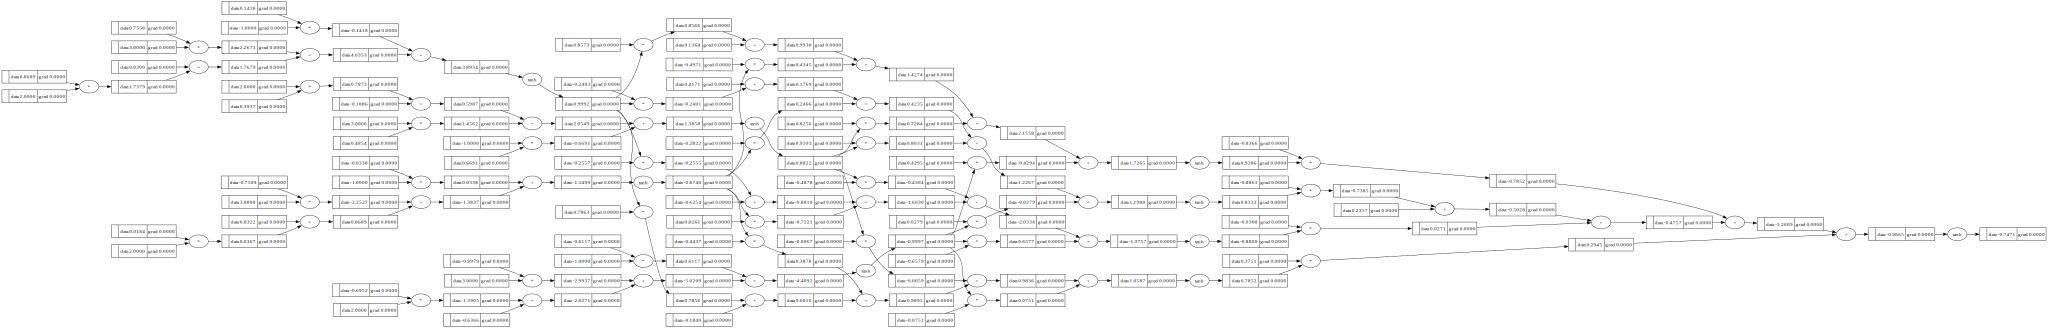

In [21]:
draw_dot(n(x))

In [22]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
y_pred=[n(x) for x in xs]
y_pred

[Value(data=-0.7471488809330902),
 Value(data=-0.5305067518355512),
 Value(data=-0.7037113377620274),
 Value(data=-0.0727779973008975)]

In [23]:
# ygt = ground truth
# yout = model output
[(yout-ygt)**2 for ygt ,yout in zip (ys,y_pred)]

[Value(data=3.0525292121457492),
 Value(data=0.22042391007200474),
 Value(data=0.0877869713707674),
 Value(data=1.1508526314929244)]

In [24]:
loss = sum([(yout-ygt)**2 for ygt ,yout in zip (ys,y_pred)])

In [25]:
loss

Value(data=4.511592725081446)

In [26]:
loss.backward()

In [27]:
n.layers[0].neurons[0].w[0].grad

0.05175073539229469

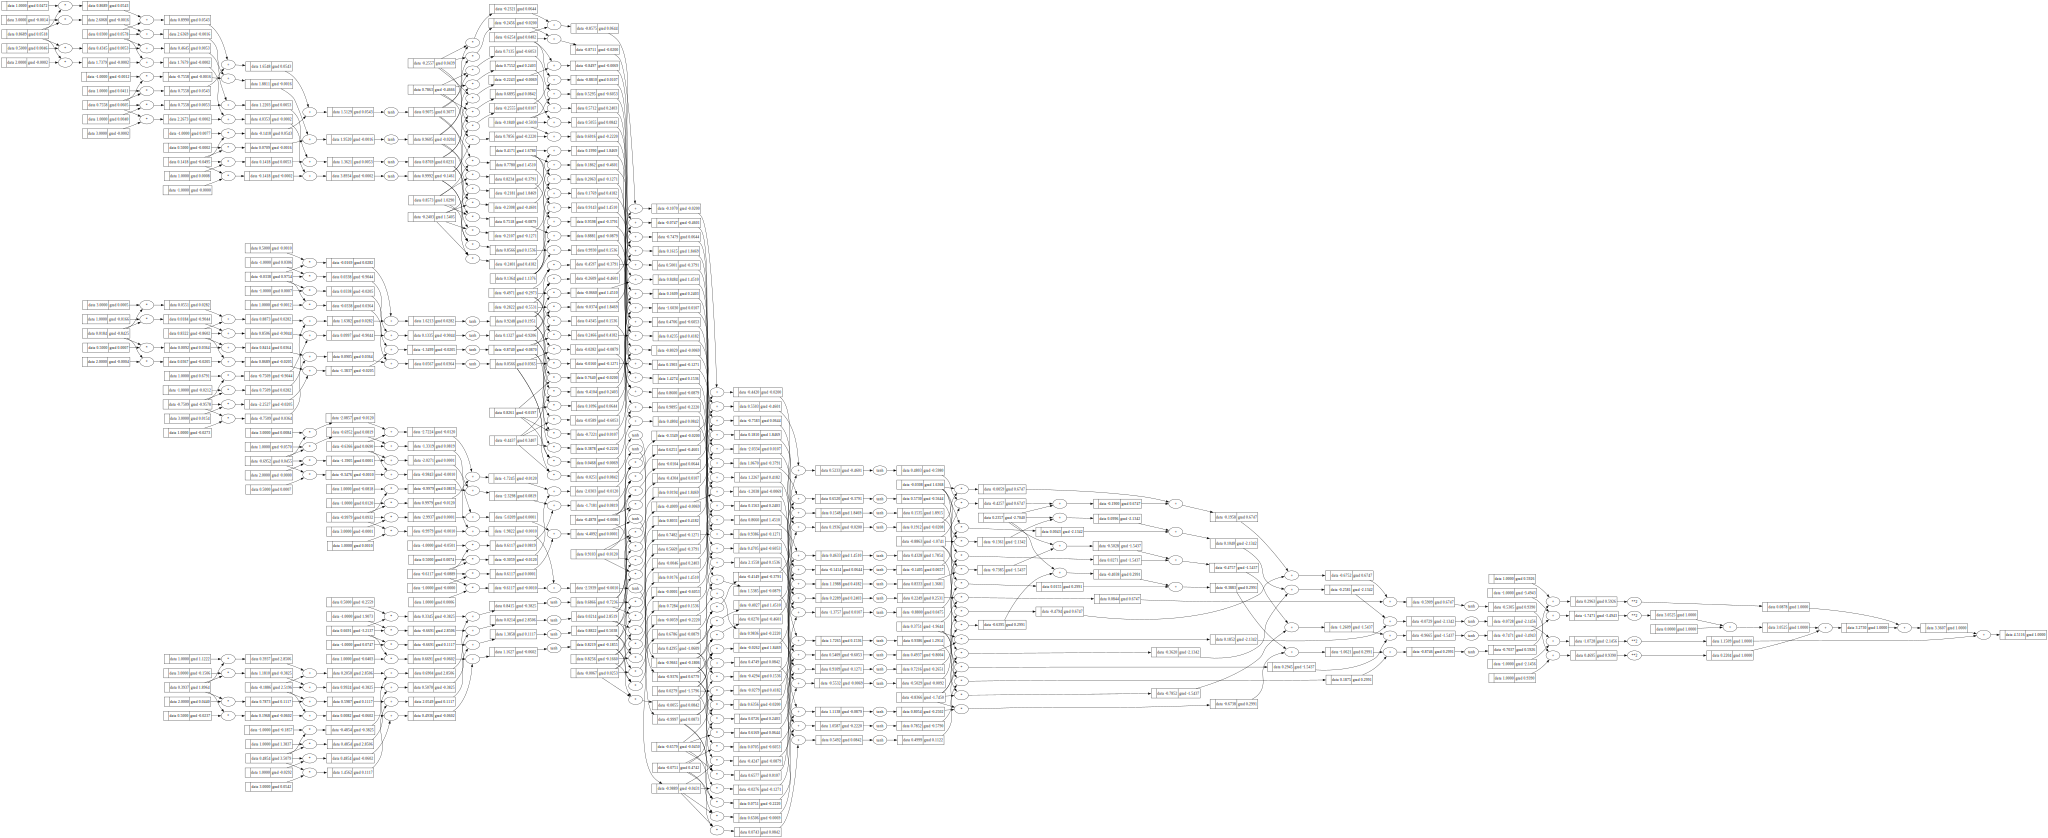

In [28]:
draw_dot(loss)

In [29]:
#included parameters for loop over each neuron
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [30]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.771226373016829)

In [31]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
y_pred=[n(x) for x in xs]
y_pred

[Value(data=-0.771226373016829),
 Value(data=0.552129351006152),
 Value(data=-0.1902223168270127),
 Value(data=-0.7816001814370983)]

In [32]:
n.parameters()

[Value(data=-0.6696851193642914),
 Value(data=-0.792010564565728),
 Value(data=0.009887120082409995),
 Value(data=0.2209033074157989),
 Value(data=-0.6593519359779945),
 Value(data=-0.5871471292953876),
 Value(data=-0.8628435807921087),
 Value(data=-0.9504052529592242),
 Value(data=0.2722442842472479),
 Value(data=0.6587130482939942),
 Value(data=-0.684518029415258),
 Value(data=-0.3296382484286844),
 Value(data=0.4435480622591159),
 Value(data=-0.6081284220180063),
 Value(data=-0.6118530093098662),
 Value(data=-0.9290375404667743),
 Value(data=0.8588170120639906),
 Value(data=-0.416467565661393),
 Value(data=0.6671361403423071),
 Value(data=-0.912769350792443),
 Value(data=0.7097510639195843),
 Value(data=0.01564806146474007),
 Value(data=-0.6576199460411216),
 Value(data=-0.7083403789219245),
 Value(data=-0.24267828123885882),
 Value(data=-0.9013163520592888),
 Value(data=-0.28118031462481485),
 Value(data=0.6993338324343574),
 Value(data=0.6031038585915933),
 Value(data=0.2804273118

In [33]:
len(n.parameters())

41

In [44]:
loss = sum([(yout-ygt)**2 for ygt ,yout in zip (ys,y_pred)])
loss

Value(data=13.493188424386734)

In [45]:
loss.backward()

In [46]:
n.layers[0].neurons[0].w[0].grad

-1.4768067898533022

In [47]:
n.layers[0].neurons[0].w[0].data

-0.7949172142803594

In [57]:
n.layers[0].neurons[0].w[0].data

-0.3518751773243688

In [58]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [90]:
for p in n.parameters():
    #learning rate here is -0.1(-ve as p.grad is -ve and we want to minimise the loss)
    p.data += -0.05 * p.grad

In [91]:
y_pred=[n(x) for x in xs]
y_pred

[Value(data=-0.7851780177141835),
 Value(data=-0.756138073270854),
 Value(data=-0.797487414052377),
 Value(data=-0.7733161419885071)]

In [92]:
loss = sum([(yout-ygt)**2 for ygt ,yout in zip (ys,y_pred)])

In [93]:
loss

Value(data=6.43199068114219)

In [94]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 6.43199068114219
1 3.9111020721315772
2 3.8753145641339333
3 4.052078600770574
4 5.336073306561744
5 5.270439980721398
6 5.2396749219205425
7 4.346822923320297
8 5.141014887727194
9 1.4979069746023206
10 1.0674784201090222
11 0.06408638104892957
12 0.05691738273025532
13 0.051155038633467605
14 0.04641247132934552
15 0.04243834550558756
16 0.039059711801409616
17 0.036152686137559606
18 0.033625813594613516
19 0.03140994616647498


In [95]:
ypred

[Value(data=0.9170856753106924),
 Value(data=-0.9377095918738488),
 Value(data=-0.9003983325418542),
 Value(data=0.8963922115725583)]